In [1]:
!pip install torchvision

Using device: cuda
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.50MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Training the GAN model...
Starting GAN training...
Epoch [1/550], Step [100/235], D Loss: 0.3761, G Loss: 3.6400
Epoch [1/550], Step [200/235], D Loss: 0.5710, G Loss: 2.4498
Epoch [2/550], Step [100/235], D Loss: 1.2795, G Loss: 0.8891
Epoch [2/550], Step [200/235], D Loss: 1.2479, G Loss: 0.9215
Epoch [3/550], Step [100/235], D Loss: 1.2013, G Loss: 0.9047
Epoch [3/550], Step [200/235], D Loss: 1.2389, G Loss: 0.8289
Epoch [4/550], Step [100/235], D Loss: 1.2138, G Loss: 0.9010
Epoch [4/550], Step [200/235], D Loss: 1.2079, G Loss: 1.0297
Epoch [5/550], Step [100/235], D Loss: 1.1937, G Loss: 1.0580
Epoch [5/550], Step [200/235], D Loss: 1.2222, G Loss: 0.9451
Epoch [6/550], Step [100/235], D Loss: 1.1857, G Loss: 0.8804
Epoch [6/550], Step [200/235], D Loss: 1.2114, G Loss: 0.9372
Epoch [7/550], Step [100/235], D Loss: 1.1414, G Loss: 1.0150
Epoch [7/550], Step [200/235], D Loss: 1.1061, G Loss: 1

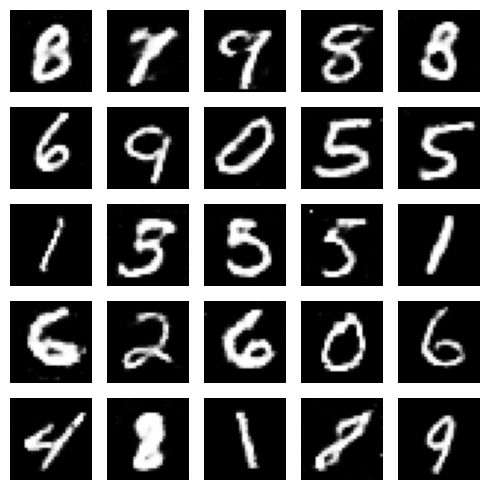

Plotting losses...


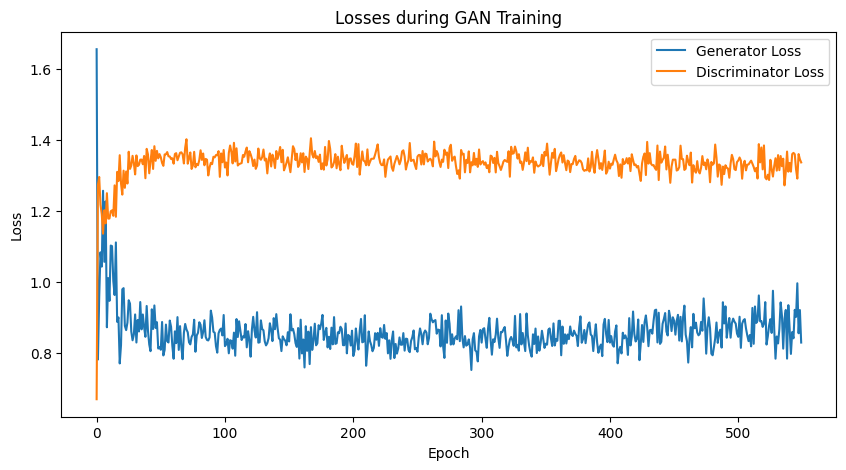

Saving the generator model...
GAN Training complete!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Set random seeds for reproducibility
torch.manual_seed(405)
np.random.seed(405)

# Hyperparameter setup
Z_DIM = 100
BATCH = 256
EPOCHS = 550
LR = 0.0002
B1 = 0.5
IMG_DIM = 28 * 28  # Flattened MNIST image (28x28)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create directory for data if it doesn't exist
os.makedirs('mnist_data', exist_ok=True)

# Define the Generator model
class Gen(nn.Module):
    def __init__(self):
        super(Gen, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(Z_DIM, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, IMG_DIM),
            nn.Tanh()
        )

    def forward(self, z_input):
        img_out = self.net(z_input)
        return img_out.view(img_out.size(0), 1, 28, 28)

# Define the Discriminator model
class Disc(nn.Module):
    def __init__(self):
        super(Disc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(IMG_DIM, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img_input):
        flattened_img = img_input.view(img_input.size(0), -1)
        return self.net(flattened_img)

# Load and preprocess MNIST data
def load_mnist_data():
    transform_mnist = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    dataset = torchvision.datasets.MNIST(
        root='./mnist_data',
        train=True,
        transform=transform_mnist,
        download=True
    )

    loader = DataLoader(
        dataset=dataset,
        batch_size=BATCH,
        shuffle=True,
        num_workers=2
    )

    return loader

# Initialize models
def initialize_models():
    g_model = Gen().to(DEVICE)
    d_model = Disc().to(DEVICE)

    def initialize_weights(layer):
        if isinstance(layer, nn.Linear):
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

    g_model.apply(initialize_weights)
    d_model.apply(initialize_weights)

    return g_model, d_model

# Train GAN
def train_gan(generator, discriminator, loader):
    criterion = nn.BCELoss()

    # Define optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(B1, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(B1, 0.999))

    g_losses = []
    d_losses = []

    print("Starting GAN training...")
    for epoch in range(EPOCHS):
        for batch_idx, (real_imgs, _) in enumerate(loader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(DEVICE)

            # Label smoothing
            real_label = torch.ones(batch_size, 1).to(DEVICE) * 0.9
            fake_label = torch.zeros(batch_size, 1).to(DEVICE)

            # Train Discriminator
            d_optimizer.zero_grad()
            real_pred = discriminator(real_imgs)
            real_loss = criterion(real_pred, real_label)

            noise = torch.randn(batch_size, Z_DIM).to(DEVICE)
            fake_imgs = generator(noise)
            fake_pred = discriminator(fake_imgs.detach())
            fake_loss = criterion(fake_pred, fake_label)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            g_pred = discriminator(fake_imgs)
            g_loss = criterion(g_pred, real_label)
            g_loss.backward()
            g_optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{batch_idx+1}/{len(loader)}], '
                      f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    return g_losses, d_losses

# Generate sample images
def generate_images(generator, sample_count=25):
    generator.eval()
    with torch.no_grad():
        noise_input = torch.randn(sample_count, Z_DIM).to(DEVICE)
        generated_imgs = generator(noise_input).cpu()

    fig, axes = plt.subplots(5, 5, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_imgs[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot training losses
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Losses during GAN Training')
    plt.show()

# Save the generator model and its weights
def save_generator(generator):
    # Save the model architecture
    gen_arch = {
        'latent_size': Z_DIM,
        'hidden_layers': [256, 512, 1024],
        'output_size': IMG_DIM
    }

    with open('generator.json', 'w') as file:
        json.dump(gen_arch, file)

    # Save weights in .h5 format
    torch.save(generator.state_dict(), 'generator.h5')

# Main execution
def run():
    print(f"Using device: {DEVICE}")

    # Load dataset
    data_loader = load_mnist_data()

    # Initialize models
    gen_model, disc_model = initialize_models()

    # Start training the GAN
    print("Training the GAN model...")
    gen_losses, disc_losses = train_gan(gen_model, disc_model, data_loader)

    # Generate and display sample images
    print("Generating sample images...")
    generate_images(gen_model)

    # Plot losses
    print("Plotting losses...")
    plot_losses(gen_losses, disc_losses)

    # Save the generator model and weights
    print("Saving the generator model...")
    save_generator(gen_model)

    print("GAN Training complete!")

if __name__ == "__main__":
    run()


In [6]:
import torch
import matplotlib.pyplot as plt

# Define the Generator model (same as before)
class Gen(nn.Module):
    def __init__(self):
        super(Gen, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(Z_DIM, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, IMG_DIM),
            nn.Tanh()
        )

    def forward(self, z_input):
        img_out = self.net(z_input)
        return img_out.view(img_out.size(0), 1, 28, 28)

# Load the trained generator model
def load_trained_generator():
    gen_model = Gen().to(DEVICE)
    gen_model.load_state_dict(torch.load('generator.h5', map_location=DEVICE))
    gen_model.eval()
    return gen_model

# Generate and save the final output image
def generate_and_save_final_image(generator, sample_count=25, save_path='final_generated_image.png'):
    generator.eval()
    with torch.no_grad():
        noise_input = torch.randn(sample_count, Z_DIM).to(DEVICE)
        generated_imgs = generator(noise_input).cpu()

    fig, axes = plt.subplots(5, 5, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_imgs[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_path)  # Save the generated image
    plt.close()
    print(f"Final generated image saved as {save_path}")

# Main execution
if __name__ == "__main__":
    # Load the pre-trained generator model
    gen_model = load_trained_generator()

    # Generate and save the final output image
    print("Generating and saving the final output image...")
    generate_and_save_final_image(gen_model)


<ipython-input-6-7d6cebeee71d>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load('generator.h5', map_location=DEVICE))


Generating and saving the final output image...
Final generated image saved as final_generated_image.png
